## Метрики и простейшие алгоритмы рекомендаций

## Начало

In [1]:
# for our own good...
!pip install -q swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.8 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done


In [2]:
import swifter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from collections import defaultdict
import random

%matplotlib inline

## О задании

В этой работе мы попробуем разработать самые простые модели для рекомендаций, а далее применить SSL методы. В первую очередь вступительная часть окажется полезна в качестве бейзлайна, с которым мы будем сравниваться. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Поэтому в идельном мире подобный эксперимент стоило бы провести на других датасетах. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

In [3]:
df = pd.read_csv('/kaggle/input/tmptmp/interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


Как мы видим, тут есть юзер, который смотрел фильм item_id last_watch_dt числа на протяжении total_dur времени и просмотрел по итогу watched_pct процентов фильма

In [4]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.swifter.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

Dask Apply:   0%|          | 0/9 [00:00<?, ?it/s]

,user_id,item_id,last_watch_dt,total_dur,watched_pct
3479944,305515,5453,126,1473,23.0
4811382,103905,13865,93,6861,100.0
5143830,173464,1844,42,4,0.0
4483916,368657,9178,20,377,100.0
1077014,271767,15297,112,8391,25.0


Сделаем разбиение по времени

<Axes: >

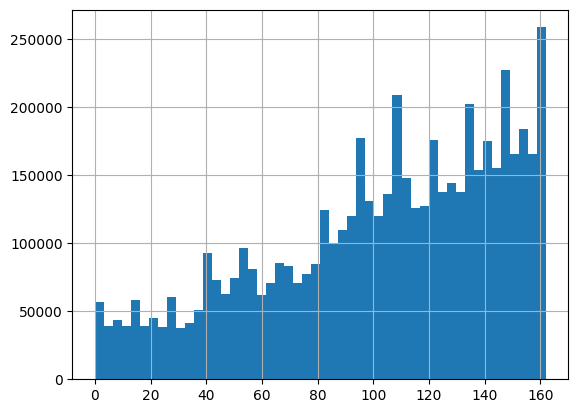

In [5]:
df.last_watch_dt.hist(bins=50)

In [6]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [7]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [8]:
np.random.seed(777)

n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [9]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
32,141674,3813,60,129,2.0
71,785328,13165,13,7,1.0
131,470881,11800,100,909,19.0
183,339681,13865,92,6460,100.0
247,284039,9728,122,604,9.0


Создаем новый датасет, где для каждого юзера храним массив из пар - фильм и когда он его посмотрел

In [10]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ..."
1,446,"[(13865, 105)]"
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865..."
3,545,"[(10440, 92), (5803, 92), (6106, 103), (6455, ..."
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70..."


In [11]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]"
1,446,"[(13865, 105)]","[(12202, 160), (230, 160)]"
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,..."
3,545,"[(10440, 92), (5803, 92), (6106, 103), (6455, ...","[(6638, 158), (5693, 161)]"
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70...","[(11118, 153), (6192, 154)]"


Допустим попробуем рандом

In [12]:
np.random.seed(69)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[3777, 747, 12754]"
1,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[3777, 747, 12754]"
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[3777, 747, 12754]"
3,545,"[(10440, 92), (5803, 92), (6106, 103), (6455, ...","[(6638, 158), (5693, 161)]","[3777, 747, 12754]"
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70...","[(11118, 153), (6192, 154)]","[3777, 747, 12754]"


**Метрики и бейзлайны**
 

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [13]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if not len(gt_items) or not len(predictions):
        return 0.0
    
    if topn is None or topn > len(predictions):
        topn = len(predictions)
    
    pred_items = np.array(predictions[:topn])
    is_hit = np.isin(pred_items, gt_items)
    num_hits = np.cumsum(is_hit)
    idxs = np.arange(1, topn + 1)
    precision = num_hits / idxs
    mask = is_hit
    ap = np.sum(precision * mask) / min(len(gt_items), topn)
    
    return ap

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    
    is_hit = np.in1d(np.array(predictions[:topn]), gt_items)
    rel_pos = np.where(is_hit)[0]
    if len(rel_pos) > 0:
        rr = 1. / (rel_pos[0] + 1)
    else:
        rr = 0.
    
    return rr

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    
    pred_items = np.array(predictions[:topn])
    hit = int(np.any(np.isin(gt_items, pred_items)))
    
    return hit


В файле `metric_tests.py` есть тесты

В следующей ячейке код, который считает и усредняет метрики по юзерам

In [14]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Как мы видим, рандом выбивает хоть какое-то качество, но не очень большое.

In [15]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0015916666666666664, 'mrr': 0.00315, 'hr': 0.0055}

Модифицируем банальными самыми популярными айтемами

In [16]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,545,"[(10440, 92), (5803, 92), (6106, 103), (6455, ...","[(6638, 158), (5693, 161)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70...","[(11118, 153), (6192, 154)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания показали более высокое качество.

In [17]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06686928659611992, 'mrr': 0.12068281746031746, 'hr': 0.2768}

**Рекомендации в окне**

Переделываем метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [18]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            interactions_lst = sorted(row[col], key=lambda x: x[1], reverse=True)
            last_date = interactions_lst[0][1]  # The starting point is the nearest day
            total_cnt = self.min_window * 30  # we take min_window months <=> days
            border_day = last_date - total_cnt
            interactions_lst = [tup for tup in interactions_lst if tup[1] >= border_day]  # отрезаем все ненужные месяцы
            for item, _ in interactions_lst:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1


        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

Теперь строим графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

In [19]:
# your code here
results = defaultdict(list)

for i in range(1, 7):
    top_popular = TopPopularWeighted(min_window=i)
    top_popular.fit(joined)
    joined['top_popular_weighted_recs'] = top_popular.predict(joined)
    print(evaluate_recommender(joined, model_preds='top_popular_weighted_recs'))
    for key, value in evaluate_recommender(joined, model_preds='top_popular_weighted_recs').items():
        results[key].append(value)

{'map': 0.06985192924855127, 'mrr': 0.12475059523809523, 'hr': 0.3046}
{'map': 0.06879833125472411, 'mrr': 0.12329694444444445, 'hr': 0.3044}
{'map': 0.06917643795666416, 'mrr': 0.1234713888888889, 'hr': 0.3044}
{'map': 0.06686928659611992, 'mrr': 0.12068281746031746, 'hr': 0.2768}
{'map': 0.06686928659611992, 'mrr': 0.12068281746031746, 'hr': 0.2768}
{'map': 0.06686928659611992, 'mrr': 0.12068281746031746, 'hr': 0.2768}


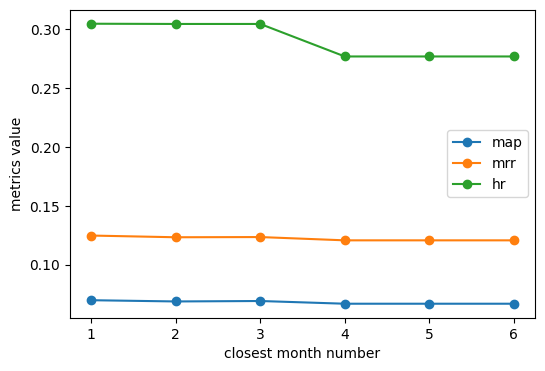

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

for key in results:
    ax.plot(range(1, 7), results[key], label=key, marker='o')
    ax.set_xlabel('closest month number')
    ax.set_ylabel('metrics value')
    ax.legend()

Наилучшее значение метрик в точке, где мы берем ближайший месяц. При увеличении размера окна (количества месяцев) растет и объем выборки, некоторые данные могут быть уже нерелевантны/устаревши. Теряется актуальность текущих предпочтений пользователя, поэтому разумнее брать окно размера 1,2,3 в зависимости от задачи

**Метрики и k.**

Строим зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмем какие-нибудь k, например, от 1 до 100

In [21]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [22]:
# your code here
results = defaultdict(list)

top_popular = TopPopular()
top_popular.fit(joined)
for i in range(1, 100 + 1):
    joined['toppopular_recs'] = top_popular.predict(joined, topn=i)
    for key, value in evaluate_recommender(joined, model_preds='toppopular_recs').items():
        results[key].append(value)

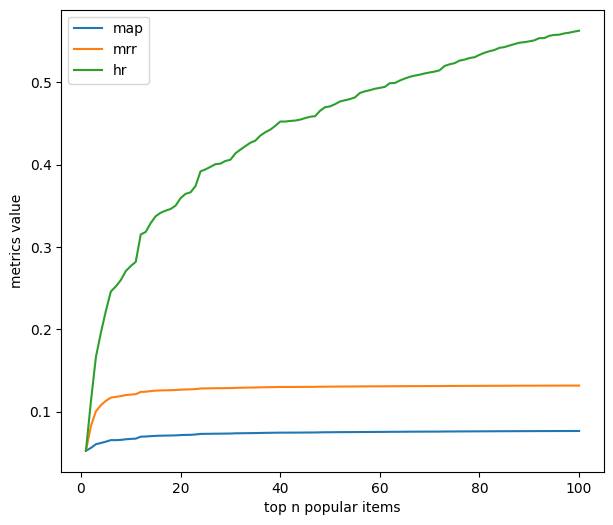

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

for key in results:
    plt.plot(range(1, 101), results[key], label=key)
    ax.set_xlabel('top n popular items')
    ax.set_ylabel('metrics value')
    ax.legend()

**hr** монотонный, потому что при увеличении k у нас к метрике прибавляется либо 0 либо 1/кол-во релевантных

**map** монотонный, потому что мы в числителе учитываем количество релевантных айтемов, а оно не уменьшается при увеличении topn

**mrr** монотонный, потому что мы при увеличении к не будем игнорировать релевантные айтемы, так что метрика не будет уменьшаться

**интерпретация hr** - самые релевантные пользователю айтемы потенциально самые популярные, поэтому там резкий скачок и плато

**интерпретация map** так выглядит, потому что пользователю надоедает смотреть одни и те же фильмы и релевантными айтемами становятся какие-то новые / непросмотренные фильмы

**интерпретация mrr** - его увеличение показывает более точное ранжирование рекомендаций. Такой скачок показывает, что пользователи сначала смотрят на более релевантный контент.

## SSL

### Temporal Order Verification

![Alt text](image.png)

In [24]:
from torch.utils.data import Dataset, DataLoader
# from ssl_solution import train_ssl_model, generate_recommendations
# from ssl_solution import TemporalInteractionDataset, TemporalVerificationModel

In [25]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict
import random
from torch.nn.utils.rnn import pad_sequence

In [26]:

def remove_random_interactions(
    sequence: List[Tuple[int, int]],
    remove_percent: float = 0.6,
) -> List[Tuple[int, int]]:
    if not sequence:
        return []

    num_to_keep = max(1, int(len(sequence) * (1 - remove_percent)))
    keep_indices = sorted(random.sample(range(len(sequence)), num_to_keep))
    return [sequence[i] for i in keep_indices]


def add_random_interactions(
    sequence: List[Tuple[int, int]], 
    available_item_ids: List[int],
    add_percent: float = 0.2,
    max_days: int = 180,
) -> List[Tuple[int, int]]:
    if not sequence or not available_item_ids:
        return sequence
    num_to_add = max(1, int(len(sequence) * add_percent))
    new_interactions = [
        (random.choice(available_item_ids), random.randint(0, max_days))
        for _ in range(num_to_add)
    ]
    augmented_sequence = sequence + new_interactions
    return sorted(augmented_sequence, key=lambda x: x[1])


In [27]:
class TemporalEncoder(nn.Module):
    def __init__(self, num_items: int, embedding_dim: int = 128, num_layers: int = 2):
        super().__init__()
        self.item_embeddings = nn.Embedding(num_items *10, embedding_dim, padding_idx=0)
        self.temporal_embeddings = nn.Linear(1, embedding_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=4),
            num_layers=num_layers
        )
    
    def forward(self, sequences):
        if not isinstance(sequences, torch.Tensor):
            sequences = torch.tensor(sequences, dtype=torch.float)
        
        if len(sequences.shape) == 2:
            sequences = sequences.unsqueeze(0)
        
        # print("LOG: sequences shape: ", sequences.shape)
        item_ids = sequences[..., 0].long()
        times = sequences[..., 1].unsqueeze(-1).float()
        # print("LOG: item_ids: ", item_ids)
        # print("LOG: times: ", times)
        
        item_emb = self.item_embeddings(item_ids)
        # print("LOG: item_emb: ", item_emb)
        time_emb = self.temporal_embeddings(times)
        # print("LOG: time_emb: ", time_emb)
        
        x = item_emb + time_emb
        output = self.transformer(x.transpose(0, 1)).transpose(0, 1)
        return output

In [28]:

class TemporalInteractionDataset(Dataset):
    def __init__(
        self,
        user_ids: List[int],
        train_interactions: List[List[Tuple[int, int]]],
        all_items: List[int],
    ):
        self.user_ids = user_ids
        self.train_interactions = train_interactions
        self.all_items = all_items
        self.max_seq_len = max(len(seq) for seq in train_interactions)
        
    def __len__(self):
        return len(self.user_ids)
    
    def temporal_verification_augment(
        self,
        sequence: List[Tuple[int, int]],
    ) -> Tuple[List[Tuple[int, int]], int]:
        sorted_seq = sorted(sequence, key=lambda x: x[1])
        
        if random.random() < 0.5:
            return sorted_seq, 1
        else:
            if random.random() < 0.5:
                shuffled = sorted_seq.copy()
                random.shuffle(shuffled)
                return shuffled, 0
            else:
                if random.random() < 0.5:
                    shorted_seq = remove_random_interactions(sorted_seq)
                    return shorted_seq, 0
                else:
                    bigger_seq = add_random_interactions(
                        sorted_seq,
                        self.all_items,
                    )
                    return bigger_seq, 0
    
    def pad_sequence(self, sequence: List[Tuple[int, int]]) -> torch.Tensor:

        seq_array = np.array(sequence, dtype=np.float32)
        seq_tensor = torch.from_numpy(seq_array)
        # seq_tensor = torch.tensor([(item, time) for item, time in sequence], dtype=torch.float)
        
        # Add padding if needed
        padding_size = self.max_seq_len - len(sequence)
        if padding_size > 0:
            padding = torch.zeros((padding_size, 2), dtype=torch.float)
            seq_tensor = torch.cat([seq_tensor, padding], dim=0)
        return seq_tensor

    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        sequence = self.train_interactions[idx]


        if not sequence:
            empty_tensor = torch.zeros((self.max_seq_len, 2), dtype=torch.float32)
            return {
                'user_id': torch.tensor(user_id, dtype=torch.long),
                'sequence': empty_tensor,
                'aug_sequence': empty_tensor,
                'label': torch.tensor(0, dtype=torch.float32),
            }

        aug_sequence, label = self.temporal_verification_augment(sequence)
        padded_sequence = self.pad_sequence(sequence)
        padded_aug_sequence = self.pad_sequence(aug_sequence)
        # print(f"Dataset item {idx}:")
        # print(f"Sequence shape: {padded_sequence.shape}")
        # print(f"Sequence item IDs: {padded_sequence[:, 0]}")  # Should be integers
        # print(f"Sequence times: {padded_sequence[:, 1]}")  

        return {
            'user_id': torch.tensor(user_id, dtype=torch.long),
            'sequence': padded_sequence,
            'aug_sequence': padded_aug_sequence,
            'label': torch.tensor(label, dtype=torch.float),
        }

In [29]:

class TemporalVerificationModel(nn.Module):
    def __init__(self, num_items: int, embedding_dim: int = 128):
        super().__init__()
        self.encoder = TemporalEncoder(num_items, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, 1)
        
    def forward(self, sequence, aug_sequence):
        # Now we apply the encoder here, not in the dataset
        # print(f"LOG: current sequence: {sequence}")
        seq_encoding = self.encoder(sequence).mean(dim=1)
        # print(f"LOG: current aug_sequence: {aug_sequence}")
        aug_encoding = self.encoder(aug_sequence).mean(dim=1)
        diff = torch.abs(seq_encoding - aug_encoding)
        return torch.sigmoid(self.classifier(diff))

In [30]:


def train_ssl_model(model, train_loader, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"Training on device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            pred = model(batch['sequence'], batch['aug_sequence'])
            loss = criterion(pred.squeeze(), batch['label'].float())
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

In [40]:
all_items = set()
for train_interaction in joined['train_interactions']:
    for item, n_days_ago in train_interaction:
        all_items.add(item)
all_items = list(all_items)
num_unique_items = len(all_items)*2

In [41]:
dataset = TemporalInteractionDataset(joined['user_id'], joined['train_interactions'], all_items)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [42]:
model = TemporalVerificationModel(num_items=num_unique_items)

In [43]:
train_ssl_model(model, loader, 15)

Training on device: cuda


  7%|▋         | 1/15 [00:26<06:17, 26.99s/it]

Epoch 1, Loss: 0.6417


 13%|█▎        | 2/15 [00:53<05:50, 26.98s/it]

Epoch 2, Loss: 0.5782


 20%|██        | 3/15 [01:20<05:23, 26.98s/it]

Epoch 3, Loss: 0.5594


 27%|██▋       | 4/15 [01:47<04:56, 26.98s/it]

Epoch 4, Loss: 0.5450


 33%|███▎      | 5/15 [02:14<04:29, 26.98s/it]

Epoch 5, Loss: 0.5291


 40%|████      | 6/15 [02:41<04:02, 26.98s/it]

Epoch 6, Loss: 0.5289


 47%|████▋     | 7/15 [03:08<03:35, 26.98s/it]

Epoch 7, Loss: 0.6889


 53%|█████▎    | 8/15 [03:35<03:08, 26.98s/it]

Epoch 8, Loss: 0.6912


 60%|██████    | 9/15 [04:02<02:41, 26.98s/it]

Epoch 9, Loss: 0.6939


 67%|██████▋   | 10/15 [04:29<02:14, 26.96s/it]

Epoch 10, Loss: 0.6936


 73%|███████▎  | 11/15 [04:56<01:47, 26.95s/it]

Epoch 11, Loss: 0.6937


 80%|████████  | 12/15 [05:23<01:20, 26.94s/it]

Epoch 12, Loss: 0.6936


 87%|████████▋ | 13/15 [05:50<00:53, 26.94s/it]

Epoch 13, Loss: 0.6934


 93%|█████████▎| 14/15 [06:17<00:26, 26.94s/it]

Epoch 14, Loss: 0.6937


100%|██████████| 15/15 [06:44<00:00, 26.96s/it]

Epoch 15, Loss: 0.6937


In [44]:
def generate_recommendations(
    model: nn.Module,
    user_sequence: torch.Tensor,
    all_items: List[int],
    k: int = 10,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> List[int]:
    model.eval()
    user_sequence = user_sequence.to(device)
    
    with torch.no_grad():
        user_encoding = model.encoder(user_sequence).mean(dim=1)
        batch_size = 512
        recommendations = []
        
        for i in range(0, len(all_items), batch_size):
            batch_items = all_items[i:i + batch_size]
            
            batch_sequences = []
            for item_id in batch_items:
                candidate_seq = user_sequence.clone()
                candidate_item = torch.tensor([[[item_id, 0.0]]], device=device)
                candidate_seq = torch.cat([candidate_seq, candidate_item], dim=1)
                batch_sequences.append(candidate_seq)
            
            batch_candidates = torch.cat(batch_sequences, dim=0)
            batch_encodings = model.encoder(batch_candidates).mean(dim=1)
            batch_scores = torch.cosine_similarity(
                user_encoding.expand(len(batch_items), -1),
                batch_encodings
            )
            
            for item_id, score in zip(batch_items, batch_scores.cpu().numpy()):
                recommendations.append((item_id, score))
        
        recommendations.sort(key=lambda x: x[1], reverse=True)
        top_k_items = [item_id for item_id, _ in recommendations[:k]]
        
        return top_k_items

In [45]:
recs_TOV = []
i = 0
for user, sequence in tqdm(zip(joined['user_id'], joined['train_interactions'])):
    if i % 1000 == 0:
        print(f"LOG: {i}")
    i += 1
    user_sequence = torch.tensor([
        [(item_id, timestamp) for item_id, timestamp in sequence]
    ], dtype=torch.float)
    cur_rec = generate_recommendations(model, user_sequence, all_items, k=10)
    recs_TOV.append(cur_rec)
recs_TOV

0it [00:00, ?it/s]

LOG: 0


1000it [07:05,  2.45it/s]

LOG: 1000


2000it [14:16,  2.11it/s]

LOG: 2000


3000it [21:27,  2.39it/s]

LOG: 3000


4000it [28:35,  2.43it/s]

LOG: 4000


5000it [35:44,  2.44it/s]

LOG: 5000


6000it [42:54,  2.36it/s]

LOG: 6000


7000it [50:02,  2.36it/s]

LOG: 7000


8000it [57:08,  2.29it/s]

LOG: 8000


9000it [1:04:20,  2.44it/s]

LOG: 9000


10000it [1:11:27,  2.33it/s]


[[9308, 1309, 4733, 6382, 12245, 42, 53, 58, 180, 288],
 [0, 12, 14, 19, 23, 24, 25, 35, 46, 47],
 [9308, 35, 111, 175, 180, 466, 483, 1246, 1603, 1627],
 [9308, 125, 135, 372, 906, 2689, 2869, 2950, 3196, 4355],
 [9308, 6588, 8270, 320, 330, 494, 528, 530, 649, 682],
 [6, 12, 32, 46, 53, 54, 62, 68, 78, 97],
 [9308, 460, 488, 1513, 1968, 2575, 6208, 6669, 6947, 7549],
 [9308, 206, 377, 665, 952, 1204, 1317, 1667, 2171, 2395],
 [1608, 1856, 1926, 2599, 2809, 2812, 2924, 6846, 7605, 8068],
 [9308, 437, 14000, 270, 320, 331, 341, 421, 439, 478],
 [347, 844, 1527, 2509, 2910, 2925, 3345, 3532, 3571, 3673],
 [9308, 234, 579, 1103, 2103, 2738, 3228, 3674, 3882, 4065],
 [9308, 259, 399, 437, 563, 811, 829, 902, 956, 991],
 [14, 23, 25, 50, 54, 79, 113, 120, 125, 143],
 [7265, 7681, 9308, 28, 68, 147, 488, 760, 1108, 1573],
 [3542, 8174, 11060, 0, 1, 5, 14, 19, 23, 32],
 [9308, 15786, 98, 175, 298, 317, 386, 389, 447, 448],
 [9308, 85, 421, 849, 1042, 1640, 1987, 2830, 4135, 5926],
 [1938, 23

In [46]:
joined['TOV'] = recs_TOV
joined

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,top_popular_weighted_recs,TOV
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9308, 1309, 4733, 6382, 12245, 42, 53, 58, 18..."
1,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[0, 12, 14, 19, 23, 24, 25, 35, 46, 47]"
2,515,"[(3734, 114), (9728, 114), (4457, 115), (13865...","[(512, 158), (6330, 158), (9811, 159), (14488,...","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9308, 35, 111, 175, 180, 466, 483, 1246, 1603..."
3,545,"[(10440, 92), (5803, 92), (6106, 103), (6455, ...","[(6638, 158), (5693, 161)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9308, 125, 135, 372, 906, 2689, 2869, 2950, 3..."
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70...","[(11118, 153), (6192, 154)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9308, 6588, 8270, 320, 330, 494, 528, 530, 64..."
...,...,...,...,...,...,...,...
9995,1097098,"[(15297, 115), (14901, 116)]","[(12192, 162)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[633, 2134, 2451, 3560, 4259, 4588, 4807, 4928..."
9996,1097262,"[(3380, 15), (8063, 23)]","[(4471, 155), (10408, 155)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[1758, 8524, 12031, 14122, 15315, 170, 255, 27..."
9997,1097290,"[(10440, 140)]","[(5754, 153), (15761, 154), (7829, 160), (734,...","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[830, 2655, 3404, 3709, 3715, 3912, 4173, 7624..."
9998,1097334,"[(14266, 52), (8636, 82), (12659, 83), (4382, ...","[(7102, 157)]","[3777, 747, 12754]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9308, 8403, 9292, 0, 113, 170, 180, 586, 660,..."


In [48]:
evaluate_recommender(joined, model_preds='TOV')

{'map': 0.0004879027777777778, 'mrr': 0.001053095238095238, 'hr': 0.0037}

In [49]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0015916666666666664, 'mrr': 0.00315, 'hr': 0.0055}

In [50]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.07648464352072996, 'mrr': 0.1316282167426676, 'hr': 0.5626}

In [51]:
evaluate_recommender(joined, model_preds='top_popular_weighted_recs')

{'map': 0.06686928659611992, 'mrr': 0.12068281746031746, 'hr': 0.2768}